## You're ready to put into practice everything that you've learned so far. Here are the next steps for your capstone:







In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest

from category_encoders import LeaveOneOutEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sqlalchemy import create_engine

import warnings

warnings.filterwarnings('ignore')

## 1) Go out and find a dataset of interest. It could be from one of the recommended resources or some other aggregation. Or it could be something that you scraped yourself. Just make sure that it has lots of variables, including an outcome of interest to you.

* Pro football reference game info

        https://www.pro-football-reference.com/years/{1966-2017}/games.htm/games.htm#games::none


* Odds - money line, open/close lines historic info

        http://www.aussportsbetting.com/historical_data/nfl.xlsx
    

* Kaggle - NFL scores and betting data

        https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data
        
### Kaggle files:
       
* spreadspoke_scores.csv
* nfl_stadiums.csv
* nfl_teams.csv

In [2]:
all_dfs = []

# Read seasons 2000 to 2017
for year in range(2000,2018):
    print(year)
    url = "https://www.pro-football-reference.com/years/" + str(year) + "/games.htm#games::none"
    df = pd.read_html(url)
    df = df[0]
    df['Year'] = year

    all_dfs.append(df)
    
scores1_df = pd.concat(all_dfs)
scores1_df.shape

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


(5096, 15)

In [3]:
scores1_df.shape

(5096, 15)

In [4]:
odds_df = pd.read_excel("http://www.aussportsbetting.com/historical_data/nfl.xlsx")
scores2_df = pd.read_csv('data/spreadspoke_scores.csv', encoding = "ISO-8859-1", engine='python')
stadiums_df = pd.read_csv('data/nfl_stadiums.csv', encoding = "ISO-8859-1", engine='python')
teams_df = pd.read_csv('data/nfl_teams.csv', encoding = "ISO-8859-1", engine='python')

## 2) Explore the data. Get to know the data. Spend a lot of time going over its quirks. You should understand how it was gathered, what's in it, and what the variables look like.

In [5]:
scores1_df.head()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Year
0,1,Sun,September 3,1:00PM,Minnesota Vikings,NaN,Chicago Bears,boxscore,30,27,374,1,425,1,2000
1,1,Sun,September 3,1:00PM,Indianapolis Colts,@,Kansas City Chiefs,boxscore,27,14,386,2,280,1,2000
2,1,Sun,September 3,1:01PM,Washington Redskins,NaN,Carolina Panthers,boxscore,20,17,396,0,236,1,2000
3,1,Sun,September 3,1:02PM,Atlanta Falcons,NaN,San Francisco 49ers,boxscore,36,28,359,1,339,1,2000
4,1,Sun,September 3,1:02PM,Baltimore Ravens,@,Pittsburgh Steelers,boxscore,16,0,336,0,223,1,2000


In [6]:
scores1_df.shape

(5096, 15)

In [7]:
scores1_df.isna().mean()

Week          0.003532
Day           0.003532
Date          0.000000
Time          0.003532
Winner/tie    0.003532
Unnamed: 5    0.596154
Loser/tie     0.003532
Unnamed: 7    0.060047
PtsW          0.003532
PtsL          0.003532
YdsW          0.003532
TOW           0.003532
YdsL          0.003532
TOL           0.003532
Year          0.000000
dtype: float64

In [8]:
scores1_df = scores1_df.drop(columns=['Unnamed: 5', 'Unnamed: 7', 'Time'])

In [9]:
scores1_df = scores1_df.dropna()

In [10]:
scores1_df['Date'].value_counts()

Date           288
December 24     76
November 23     51
December 28     50
December 23     49
              ... 
February 6       2
February 2       1
January 28       1
September 6      1
January 26       1
Name: Date, Length: 155, dtype: int64

In [11]:
mos = {'January': 1
       ,'February': 2
       ,'March': 3
       ,'April': 4
       ,'May': 5
       ,'June': 6
       ,'July': 7
       ,'August': 8
       ,'September': 9
       ,'October': 10
       ,'November': 11
       ,'December': 12}

In [12]:
match = 'January'
for m in mos:
    if m != 'January':
        match = match + '|' + m
scores1_df = scores1_df[scores1_df['Date'].str.contains(match)]

In [13]:
scores1_df['Month'] = scores1_df['Date'].str.split(' ').str[0]
scores1_df['DayofMonth'] = scores1_df['Date'].str.split(' ').str[1].astype(int)

scores1_df['month_num'] = scores1_df['Month'].map(mos)

In [14]:
scores1_df

,Week,Day,Date,Winner/tie,Loser/tie,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Year,Month,DayofMonth,month_num
0,1,Sun,September 3,Minnesota Vikings,Chicago Bears,30,27,374,1,425,1,2000,September,3,9
1,1,Sun,September 3,Indianapolis Colts,Kansas City Chiefs,27,14,386,2,280,1,2000,September,3,9
2,1,Sun,September 3,Washington Redskins,Carolina Panthers,20,17,396,0,236,1,2000,September,3,9
3,1,Sun,September 3,Atlanta Falcons,San Francisco 49ers,36,28,359,1,339,1,2000,September,3,9
4,1,Sun,September 3,Baltimore Ravens,Pittsburgh Steelers,16,0,336,0,223,1,2000,September,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Division,Sun,January 14,Jacksonville Jaguars,Pittsburgh Steelers,45,42,378,0,545,2,2017,January,14,1
280,Division,Sun,January 14,Minnesota Vikings,New Orleans Saints,29,24,403,1,358,2,2017,January,14,1
281,ConfChamp,Sun,January 21,New England Patriots,Jacksonville Jaguars,24,20,344,1,374,0,2017,January,21,1
282,ConfChamp,Sun,January 21,Philadelphia Eagles,Minnesota Vikings,38,7,456,0,333,3,2017,January,21,1


## --------------------------------

In [15]:
odds_df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Min,...,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2020-09-14,Denver Broncos,Tennessee Titans,14,16,NaN,NaN,NaN,1.76,1.76,...,41.0,1.9,1.86,1.9,1.9,1.9,1.9,1.9,1.9,NaN
1,2020-09-14,New York Giants,Pittsburgh Steelers,16,26,NaN,NaN,NaN,2.60,2.60,...,45.0,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
2,2020-09-13,Los Angeles Rams,Dallas Cowboys,20,17,NaN,NaN,NaN,2.15,2.15,...,51.5,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
3,2020-09-13,New Orleans Saints,Tampa Bay Buccaneers,34,23,NaN,NaN,NaN,1.47,1.47,...,47.5,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
4,2020-09-13,San Francisco 49ers,Arizona Cardinals,20,24,NaN,NaN,NaN,1.28,1.28,...,48.0,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN


In [16]:
odds_df.shape

(3754, 45)

In [17]:
odds_df.describe()

,Home Score,Away Score,Home Odds Open,Home Odds Min,Home Odds Max,Home Odds Close,Away Odds Open,Away Odds Min,Away Odds Max,Away Odds Close,...,Total Score Max,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close
count,3754.000000,3754.000000,3754.000000,1618.00000,1618.000000,1618.000000,3754.000000,1618.000000,1618.000000,1618.000000,...,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000
mean,23.479489,21.238679,1.950855,1.83207,2.064315,1.954741,2.892580,2.573298,2.982897,2.780451,...,46.400494,45.441595,1.937429,1.903295,1.967795,1.933845,1.932285,1.924482,1.942302,1.936200
std,10.380618,10.035696,0.999993,0.79537,1.035032,0.912600,1.795221,1.342111,1.692837,1.560962,...,4.115823,4.115203,0.034949,0.033771,0.057890,0.041980,0.034153,0.033072,0.041815,0.043195
min,0.000000,0.000000,1.011111,1.02000,1.050000,1.020000,1.055556,1.030000,1.060000,1.050000,...,37.000000,35.000000,1.806000,1.740000,1.860000,1.740000,1.775000,1.830000,1.787000,1.813000
25%,16.000000,14.000000,1.340000,1.33300,1.416000,1.377000,1.695250,1.641000,1.813000,1.699000,...,43.500000,42.500000,1.900000,1.884000,1.900000,1.900000,1.900000,1.900000,1.900000,1.900000
50%,23.000000,21.000000,1.606061,1.57050,1.714000,1.640000,2.450000,2.250000,2.555000,2.400000,...,46.000000,45.000000,1.952000,1.900000,1.961000,1.925000,1.952000,1.909000,1.952000,1.925000
75%,30.000000,27.000000,2.250000,2.09000,2.397500,2.260000,3.480000,3.100000,3.560000,3.310000,...,49.000000,48.000000,1.952000,1.917000,2.010000,1.961000,1.952000,1.952000,1.970000,1.961000
max,62.000000,59.000000,12.000000,10.00000,15.500000,11.000000,31.000000,12.250000,16.000000,16.000000,...,63.500000,62.500000,2.170000,2.020000,2.170000,2.110000,2.120000,2.120000,2.090000,2.220000


In [18]:
odds_df.isna().mean()

Date                       0.000000
Home Team                  0.000000
Away Team                  0.000000
Home Score                 0.000000
Away Score                 0.000000
Overtime?                  0.941929
Playoff Game?              0.958977
Neutral Venue?             0.988013
Home Odds Open             0.000000
Home Odds Min              0.568993
Home Odds Max              0.568993
Home Odds Close            0.568993
Away Odds Open             0.000000
Away Odds Min              0.568993
Away Odds Max              0.568993
Away Odds Close            0.568993
Home Line Open             0.000000
Home Line Min              0.568993
Home Line Max              0.568993
Home Line Close            0.568993
Away Line Open             0.568993
Away Line Min              0.568993
Away Line Max              0.568993
Away Line Close            0.568993
Home Line Odds Open        0.568993
Home Line Odds Min         0.568993
Home Line Odds Max         0.568993
Home Line Odds Close       0

In [19]:
odds_df['Overtime?'].value_counts()

Y    218
Name: Overtime?, dtype: int64

In [20]:
odds_df['Playoff Game?'].value_counts()

Y    154
Name: Playoff Game?, dtype: int64

In [21]:
odds_df['Neutral Venue?'].value_counts()

Y    45
Name: Neutral Venue?, dtype: int64

In [22]:
odds_df['Overtime?'] = odds_df['Overtime?'].fillna('N')
odds_df['Playoff Game?'] = odds_df['Playoff Game?'].fillna('N')
odds_df['Neutral Venue?'] = odds_df['Neutral Venue?'].fillna('N')

In [23]:
odds_cols = ['Date'                       
            ,'Home Team'                 
            ,'Away Team'                 
            ,'Home Score'                
            ,'Away Score'               
            ,'Overtime?'               
            ,'Playoff Game?'            
            ,'Neutral Venue?'           
            ,'Home Odds Open'             
            ,'Away Odds Open'           
            ,'Total Score Open']         
odds_df = odds_df[odds_cols]

In [24]:
odds_df['date'] = pd.to_datetime(odds_df['Date'])
odds_df['year'] = odds_df['date'].dt.year
odds_df['month'] = odds_df['date'].dt.month
odds_df['DayofMonth'] = odds_df['date'].dt.day

In [25]:
odds_df

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Away Odds Open,Total Score Open,date,year,month,DayofMonth
0,2020-09-14,Denver Broncos,Tennessee Titans,14,16,N,N,N,1.760000,2.100000,42.0,2020-09-14,2020,9,14
1,2020-09-14,New York Giants,Pittsburgh Steelers,16,26,N,N,N,2.600000,1.550000,48.0,2020-09-14,2020,9,14
2,2020-09-13,Los Angeles Rams,Dallas Cowboys,20,17,N,N,N,2.150000,1.740000,50.0,2020-09-13,2020,9,13
3,2020-09-13,New Orleans Saints,Tampa Bay Buccaneers,34,23,N,N,N,1.470000,2.750000,49.5,2020-09-13,2020,9,13
4,2020-09-13,San Francisco 49ers,Arizona Cardinals,20,24,N,N,N,1.280000,3.750000,46.0,2020-09-13,2020,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,3.500000,1.333333,44.0,2006-09-10,2006,9,10
3750,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,1.500000,2.750000,36.5,2006-09-10,2006,9,10
3751,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,1.434783,2.900000,38.5,2006-09-10,2006,9,10
3752,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,1.181818,5.000000,43.5,2006-09-10,2006,9,10


## --------------------------------

In [26]:
scores2_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


In [27]:
scores2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12678 entries, 0 to 12677
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12678 non-null  object 
 1   schedule_season      12678 non-null  int64  
 2   schedule_week        12678 non-null  object 
 3   schedule_playoff     12678 non-null  bool   
 4   team_home            12678 non-null  object 
 5   score_home           12678 non-null  int64  
 6   score_away           12678 non-null  int64  
 7   team_away            12678 non-null  object 
 8   team_favorite_id     10199 non-null  object 
 9   spread_favorite      10199 non-null  float64
 10  over_under_line      10189 non-null  object 
 11  stadium              12678 non-null  object 
 12  stadium_neutral      12678 non-null  bool   
 13  weather_temperature  11936 non-null  float64
 14  weather_wind_mph     11936 non-null  float64
 15  weather_humidity     8388 non-null  

In [28]:
scores2_df.isna().mean()

schedule_date          0.000000
schedule_season        0.000000
schedule_week          0.000000
schedule_playoff       0.000000
team_home              0.000000
score_home             0.000000
score_away             0.000000
team_away              0.000000
team_favorite_id       0.195536
spread_favorite        0.195536
over_under_line        0.196324
stadium                0.000000
stadium_neutral        0.000000
weather_temperature    0.058527
weather_wind_mph       0.058527
weather_humidity       0.338381
weather_detail         0.791844
dtype: float64

In [29]:
scores2_df = scores2_df.drop(columns = ['weather_humidity', 'weather_detail'])

In [30]:
scores2_df = scores2_df.dropna()

In [31]:
scores2_df['DayofMonth'] = pd.to_datetime(scores2_df['schedule_date']).dt.day
scores2_df['Month'] = pd.to_datetime(scores2_df['schedule_date']).dt.month
scores2_df['year'] = pd.to_datetime(scores2_df['schedule_date']).dt.year

### Add winning team column based on scores

In [32]:
scores2_df['Winner'] = scores2_df['team_home']

scores2_df.loc[scores2_df['score_away'] > scores2_df['score_home'], 
               "Winner"] = scores2_df['team_away']

In [33]:
scores2_df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,DayofMonth,Month,year,Winner
350,1/14/1968,1967,Superbowl,True,Green Bay Packers,33,14,Oakland Raiders,GB,-13.5,43,Orange Bowl,True,60.0,12.0,14,1,1968,Green Bay Packers
538,1/12/1969,1968,Superbowl,True,Baltimore Colts,7,16,New York Jets,IND,-18.0,40,Orange Bowl,True,66.0,12.0,12,1,1969,New York Jets
727,1/11/1970,1969,Superbowl,True,Kansas City Chiefs,23,7,Minnesota Vikings,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,11,1,1970,Kansas City Chiefs
916,1/17/1971,1970,Superbowl,True,Baltimore Colts,16,13,Dallas Cowboys,IND,-2.5,36,Orange Bowl,True,59.0,11.0,17,1,1971,Baltimore Colts
1105,1/16/1972,1971,Superbowl,True,Dallas Cowboys,24,3,Miami Dolphins,DAL,-6.0,34,Tulane Stadium,True,34.0,18.0,16,1,1972,Dallas Cowboys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12655,12/29/2019,2019,17,False,Dallas Cowboys,47,16,Washington Redskins,DAL,-12.5,47.5,AT&T Stadium,False,72.0,0.0,29,12,2019,Dallas Cowboys
12657,12/29/2019,2019,17,False,Detroit Lions,20,23,Green Bay Packers,GB,-13.0,44,Ford Field,False,72.0,0.0,29,12,2019,Green Bay Packers
12658,12/29/2019,2019,17,False,Houston Texans,14,35,Tennessee Titans,TEN,-10.0,43,NRG Stadium,False,72.0,0.0,29,12,2019,Tennessee Titans
12667,1/4/2020,2019,Wildcard,True,Houston Texans,22,19,Buffalo Bills,HOU,-2.5,43,NRG Stadium,False,72.0,0.0,4,1,2020,Houston Texans


## --------------------------------

In [34]:
stadiums_df.head()

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
1,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arrowhead Stadium,"Kansas City, MO",1972.0,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.0692,-94.4871,264.9


In [35]:
stadiums_df.isna().mean()

stadium_name                    0.00
stadium_location                0.00
stadium_open                    0.24
stadium_close                   0.59
stadium_type                    0.07
stadium_address                 0.09
stadium_weather_station_code    0.10
stadium_weather_type            0.07
stadium_capacity                0.61
stadium_surface                 0.47
STATION                         0.48
NAME                            0.48
LATITUDE                        0.48
LONGITUDE                       0.48
ELEVATION                       0.48
dtype: float64

In [36]:
cols = ['stadium_name', 'stadium_location', 'stadium_type', 'stadium_weather_type', 'stadium_surface']
stadiums_df = stadiums_df[cols]

In [37]:
stadiums_df.isna().mean()

stadium_name            0.00
stadium_location        0.00
stadium_type            0.07
stadium_weather_type    0.07
stadium_surface         0.47
dtype: float64

In [38]:
stadiums_df['stadium_type'] = stadiums_df['stadium_type'].fillna('unknown')
stadiums_df['stadium_weather_type'] = stadiums_df['stadium_weather_type'].fillna('unknown')
stadiums_df['stadium_surface'] = stadiums_df['stadium_surface'].fillna('unknown')

In [39]:
stadiums_df.isna().mean()

stadium_name            0.0
stadium_location        0.0
stadium_type            0.0
stadium_weather_type    0.0
stadium_surface         0.0
dtype: float64

In [40]:
stadiums_df

,stadium_name,stadium_location,stadium_type,stadium_weather_type,stadium_surface
0,Alamo Dome,"San Antonio, TX",indoor,dome,FieldTurf
1,Alltel Stadium,"Jacksonville, FL",unknown,unknown,unknown
2,Alumni Stadium,"Chestnut Hill, MA",outdoor,cold,Grass
3,Anaheim Stadium,"Anaheim, CA",outdoor,warm,unknown
4,Arrowhead Stadium,"Kansas City, MO",outdoor,cold,Grass
...,...,...,...,...,...
95,War Memorial Stadium,"Buffalo, NY",outdoor,cold,unknown
96,Wembley Stadium,"London, UK",outdoor,moderate,unknown
97,Wrigley Field,"Chicago, IL",outdoor,cold,unknown
98,Yale Bowl,"New Haven, CT",outdoor,cold,Grass


## --------------------------------

In [41]:
teams_df.head(45)

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
5,Buffalo Bills,Bills,BUF,BUF,AFC,AFC East,AFC,AFC East
6,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South,NFC,NFC West
7,Chicago Bears,Bears,CHI,CHI,NFC,NFC North,NFC,NFC Central
8,Cincinnati Bengals,Bengals,CIN,CIN,AFC,AFC North,AFC,AFC Central
9,Cleveland Browns,Browns,CLE,CLE,AFC,AFC North,AFC,AFC Central


In [42]:
teams_df.shape

(41, 8)

In [43]:
teams_df.isna().mean()

team_name                  0.000000
team_name_short            0.000000
team_id                    0.000000
team_id_pfr                0.000000
team_conference            0.000000
team_division              0.195122
team_conference_pre2002    0.000000
team_division_pre2002      0.048780
dtype: float64

In [44]:
teams_df['team_division'] = teams_df['team_division'].fillna(teams_df['team_division_pre2002'])
teams_df['team_division'] = teams_df['team_division'].fillna('unknown')

In [45]:
teams_df = teams_df.drop(columns=['team_conference_pre2002', 'team_division_pre2002', 'team_id_pfr'])

In [46]:
teams_df

,team_name,team_name_short,team_id,team_conference,team_division
0,Arizona Cardinals,Cardinals,ARI,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,NFC,NFC South
4,Baltimore Ravens,Ravens,BAL,AFC,AFC North
5,Buffalo Bills,Bills,BUF,AFC,AFC East
6,Carolina Panthers,Panthers,CAR,NFC,NFC South
7,Chicago Bears,Bears,CHI,NFC,NFC North
8,Cincinnati Bengals,Bengals,CIN,AFC,AFC North
9,Cleveland Browns,Browns,CLE,AFC,AFC North


## Join dataframes together

In [47]:
scores1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4790 entries, 0 to 283
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        4790 non-null   object
 1   Day         4790 non-null   object
 2   Date        4790 non-null   object
 3   Winner/tie  4790 non-null   object
 4   Loser/tie   4790 non-null   object
 5   PtsW        4790 non-null   object
 6   PtsL        4790 non-null   object
 7   YdsW        4790 non-null   object
 8   TOW         4790 non-null   object
 9   YdsL        4790 non-null   object
 10  TOL         4790 non-null   object
 11  Year        4790 non-null   int64 
 12  Month       4790 non-null   object
 13  DayofMonth  4790 non-null   int32 
 14  month_num   4790 non-null   int64 
dtypes: int32(1), int64(2), object(12)
memory usage: 580.0+ KB


In [48]:
scores2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9677 entries, 350 to 12669
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        9677 non-null   object 
 1   schedule_season      9677 non-null   int64  
 2   schedule_week        9677 non-null   object 
 3   schedule_playoff     9677 non-null   bool   
 4   team_home            9677 non-null   object 
 5   score_home           9677 non-null   int64  
 6   score_away           9677 non-null   int64  
 7   team_away            9677 non-null   object 
 8   team_favorite_id     9677 non-null   object 
 9   spread_favorite      9677 non-null   float64
 10  over_under_line      9677 non-null   object 
 11  stadium              9677 non-null   object 
 12  stadium_neutral      9677 non-null   bool   
 13  weather_temperature  9677 non-null   float64
 14  weather_wind_mph     9677 non-null   float64
 15  DayofMonth           9677 non-null 

In [49]:
full_table = scores1_df.merge(scores2_df,
                              left_on=['month_num', 'DayofMonth', 'Year', 'Winner/tie'], 
                              right_on=['Month', 'DayofMonth', 'year', 'Winner'])

In [50]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4467 entries, 0 to 4466
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Week                 4467 non-null   object 
 1   Day                  4467 non-null   object 
 2   Date                 4467 non-null   object 
 3   Winner/tie           4467 non-null   object 
 4   Loser/tie            4467 non-null   object 
 5   PtsW                 4467 non-null   object 
 6   PtsL                 4467 non-null   object 
 7   YdsW                 4467 non-null   object 
 8   TOW                  4467 non-null   object 
 9   YdsL                 4467 non-null   object 
 10  TOL                  4467 non-null   object 
 11  Year                 4467 non-null   int64  
 12  Month_x              4467 non-null   object 
 13  DayofMonth           4467 non-null   int32  
 14  month_num            4467 non-null   int64  
 15  schedule_date        4467 non-null   o

In [51]:
full_table[['Date', 'Winner/tie', 'Winner', 'PtsW', 'PtsL', 'score_home', 'score_away']]

,Date,Winner/tie,Winner,PtsW,PtsL,score_home,score_away
0,September 3,Minnesota Vikings,Minnesota Vikings,30,27,30,27
1,September 3,Indianapolis Colts,Indianapolis Colts,27,14,14,27
2,September 3,Washington Redskins,Washington Redskins,20,17,20,17
3,September 3,Atlanta Falcons,Atlanta Falcons,36,28,36,28
4,September 3,Baltimore Ravens,Baltimore Ravens,16,0,0,16
...,...,...,...,...,...,...,...
4462,December 31,Cincinnati Bengals,Cincinnati Bengals,31,27,27,31
4463,December 31,Atlanta Falcons,Atlanta Falcons,22,10,22,10
4464,December 31,San Francisco 49ers,San Francisco 49ers,34,13,13,34
4465,December 31,Arizona Cardinals,Arizona Cardinals,26,24,24,26


In [52]:
full_table = full_table.merge(odds_df,
                              left_on=['month_num', 'DayofMonth', 'year', 'team_home'], 
                              right_on=['month', 'DayofMonth', 'year', 'Home Team'])

In [53]:
# Get team information from team ID
full_table = full_table.merge(teams_df,
                              left_on=['team_favorite_id'], 
                              right_on=['team_id'])

In [54]:
# Get stadium information
full_table = full_table.merge(stadiums_df,
                              left_on=['stadium'], 
                              right_on=['stadium_name'])

In [55]:
# Remove unneeded rows
full_table = full_table.drop(columns=['Date_x', 'Month_x'
                                        ,'schedule_date'
                                        ,'schedule_season'
                                        ,'schedule_playoff'
                                        ,'Week'
                                        ,'Month_y'
                                        ,'year'
                                        ,'Winner'
                                        ,'Home Score'
                                        ,'Away Score'
                                        ,'Home Team'
                                        ,'Away Team'
                                        ,'Date_y'
                                        ,'team_name_short'
                                        ,'team_id'
                                        ,'month_num'])


In [56]:
# Rename columns
full_table.rename(columns = {'Day':'weekday'
                             ,'Winner/tie':'winner'
                             ,'Loser/tie':'loser'
                             ,'PtsW':'pts_win' 
                             ,'PtsL':'pts_lose'
                             ,'YdsW':'yds_win' 
                             ,'YdsL':'yds_lose'
                             ,'TOW':'TO_win' 
                             ,'TOL':'TO_lose'
                             ,'Year':'year'
                             ,'weather_temperature':'w_temp'
                             ,'weather_wind_mph':'w_wind_mph'
                             ,'Overtime?':'overtime'
                             ,'Playoff Game?':'playoff'
                             ,'Neutral Venue?':'neutral_venue'
                             ,'Home Odds Open':'home_odds_open'
                             ,'Away Odds Open':'away_odds_open'
                             ,'Total Score Open':'total_score_open'
                             ,'team_name':'team_fav_name'
                             ,'team_conference':'team_fav_conf'
                             ,'team_division':'team_fav_div'
                             }
                             , inplace = True)

In [57]:
# Get yards, points, turnover differences
full_table['yds_diff'] = full_table['yds_win'].astype(int) - full_table['yds_lose'].astype(int)
full_table['pts_diff'] = full_table['pts_win'].astype(int) - full_table['pts_lose'].astype(int)
full_table['TO_diff'] = full_table['TO_win'].astype(int) - full_table['TO_lose'].astype(int)

In [58]:
# Remove the difference rows
full_table = full_table.drop(columns=['yds_win', 'yds_lose', 'pts_win', 'pts_lose', 
                                      'TO_win', 'TO_lose'])

In [68]:
full_table['schedule_week'].value_counts()

15          246
1           243
12          241
16          235
2           233
3           232
13          230
14          228
5           214
11          212
4           211
10          209
8           208
7           206
6           197
9           196
17          143
Division      1
Wildcard      1
Name: schedule_week, dtype: int64

In [74]:
full_table['schedule_week'] = full_table[full_table['schedule_week'].any(['Division', 'Wildcard'])]

TypeError: unhashable type: 'list'

In [67]:
# Convert certain rows to integers
full_table['schedule_week'] = full_table['schedule_week'].astype(int)
full_table['over_under_line'] = full_table['over_under_line'].astype(int)

ValueError: invalid literal for int() with base 10: 'Wildcard'

## 3) Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power, and experiment with both.

In [59]:
cols = full_table.columns
cols

Index(['weekday', 'winner', 'loser', 'year', 'DayofMonth', 'schedule_week',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'w_temp', 'w_wind_mph', 'overtime', 'playoff',
       'neutral_venue', 'home_odds_open', 'away_odds_open', 'total_score_open',
       'date', 'month', 'team_fav_name', 'team_fav_conf', 'team_fav_div',
       'stadium_name', 'stadium_location', 'stadium_type',
       'stadium_weather_type', 'stadium_surface', 'yds_diff', 'pts_diff',
       'TO_diff'],
      dtype='object')

## Target: predict if home team will win based on previous 2 games
* points scored
* point difference
* won/lost
* temp and wind

## Target: points difference based on previous 2 games

https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group/53335744#53335744

## Use pipelines

## Find and handle outliers

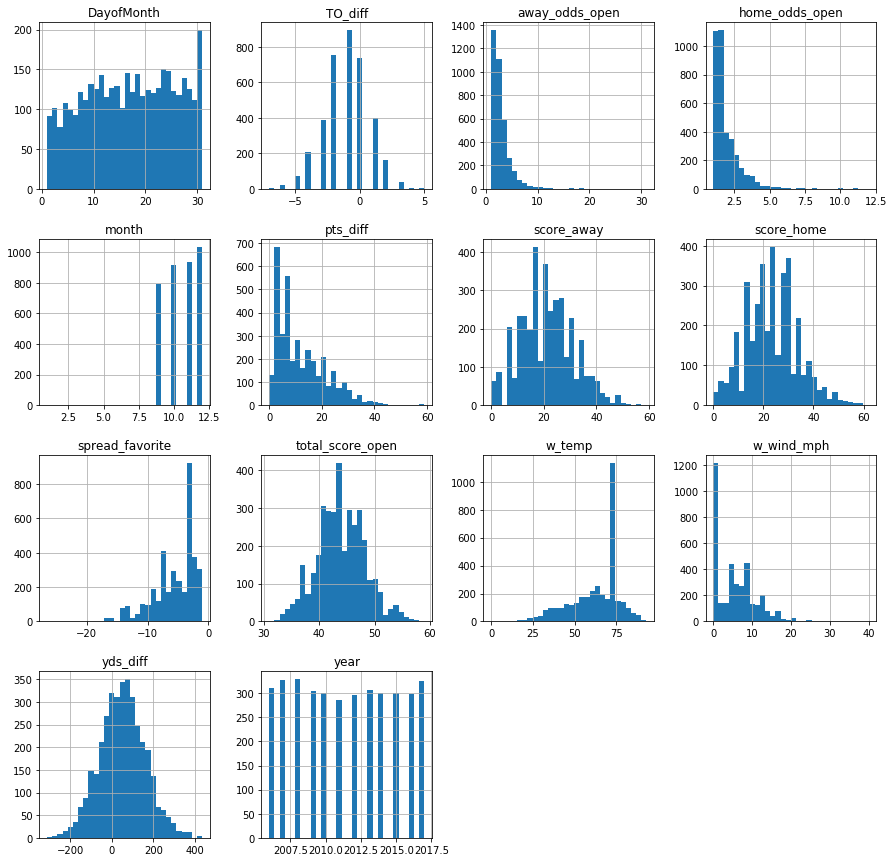

In [60]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = full_table.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

In [61]:
corrmat = full_table.corr()

In [62]:
corrmat

,year,DayofMonth,score_home,score_away,spread_favorite,stadium_neutral,w_temp,w_wind_mph,home_odds_open,away_odds_open,total_score_open,month,yds_diff,pts_diff,TO_diff
year,1.000000,-0.016119,0.044953,0.025420,0.107250,0.029648,0.091284,-0.167911,-0.028954,-0.065198,0.319579,-0.015112,-0.025422,-0.040569,0.040132
DayofMonth,-0.016119,1.000000,0.008770,-0.014749,-0.027092,0.044194,-0.060211,0.027856,0.016778,0.012880,-0.012785,-0.054982,-0.006462,0.039512,-0.046176
score_home,0.044953,0.008770,1.000000,-0.083900,-0.149795,-0.036838,-0.015876,-0.083967,-0.259185,0.257147,0.192399,-0.003164,0.062888,0.240133,-0.055701
score_away,0.025420,-0.014749,-0.083900,1.000000,0.144174,0.041753,0.055001,-0.068737,0.276908,-0.262295,0.177346,-0.014702,-0.112291,-0.088916,-0.042760
spread_favorite,0.107250,-0.027092,-0.149795,0.144174,1.000000,-0.003269,0.111155,-0.047070,-0.037152,-0.730058,-0.038338,-0.093165,-0.159803,-0.148024,-0.040435
stadium_neutral,0.029648,0.044194,-0.036838,0.041753,-0.003269,1.000000,-0.007302,0.027562,0.118799,-0.055761,0.010692,-0.009192,0.017279,0.048705,-0.020641
w_temp,0.091284,-0.060211,-0.015876,0.055001,0.111155,-0.007302,1.000000,-0.325868,0.010838,-0.089159,0.111792,-0.467672,-0.015570,-0.043837,0.038507
w_wind_mph,-0.167911,0.027856,-0.083967,-0.068737,-0.047070,0.027562,-0.325868,1.000000,0.034472,0.032326,-0.222647,0.023659,0.026828,0.035587,-0.011093
home_odds_open,-0.028954,0.016778,-0.259185,0.276908,-0.037152,0.118799,0.010838,0.034472,1.000000,-0.511145,0.042646,0.032670,0.003765,-0.002110,0.007279
away_odds_open,-0.065198,0.012880,0.257147,-0.262295,-0.730058,-0.055761,-0.089159,0.032326,-0.511145,1.000000,0.008455,0.038133,0.117464,0.110662,0.038447


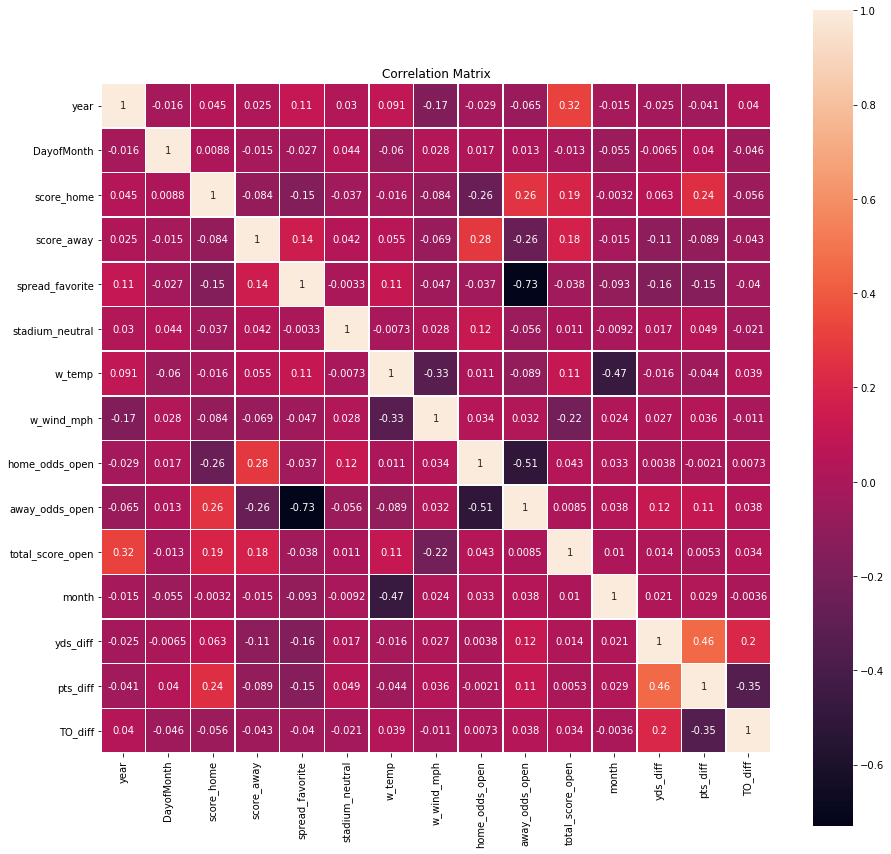

In [63]:
plt.figure(figsize=(15, 15))

sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix")

plt.show()

In [64]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3686 entries, 0 to 3685
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   weekday               3686 non-null   object        
 1   winner                3686 non-null   object        
 2   loser                 3686 non-null   object        
 3   year                  3686 non-null   int64         
 4   DayofMonth            3686 non-null   int32         
 5   schedule_week         3686 non-null   object        
 6   team_home             3686 non-null   object        
 7   score_home            3686 non-null   int64         
 8   score_away            3686 non-null   int64         
 9   team_away             3686 non-null   object        
 10  team_favorite_id      3686 non-null   object        
 11  spread_favorite       3686 non-null   float64       
 12  over_under_line       3686 non-null   object        
 13  stadium           

In [65]:
# Fill out your column datatypes here
num_cols = []

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer([
    # Should only use one of these
    # Comment out or delete one of the below 2 lines
    ('OneHotEncoder', OneHotEncoder(drop=drop_cats), cat_cols),    
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns (not needed for all models but can't hurt)
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')


pipeline = Pipeline([
    ('preprocessing', preprocessing),
    # Choose your model and put it here
    ('model', XGBClassifier())
])


grid = {
    # Use model__ with hyperprammeter names after
    'model__n_estimators':[100, 150]    
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train)

print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))


NameError: name 'XGBClassifier' is not defined

## Next, to prepare for your presentation, create a slide deck and a 15-minute presentation that guides viewers through your model. Be sure to cover a few specific topics:

* ## A specified research question that your model addresses
* ## How you chose your model specification and what alternatives you compared it to
* ## The practical uses of your model for an audience of interest
* ## Any weak points or shortcomings of your model

## This presentation is not a drill. You'll be presenting this slide deck live to a group as the culmination of all your work so far on supervised learning. As a secondary matter, your slides and the Jupyter Notebook should be worthy of inclusion as examples of your work product when applying to jobs.